# <span style="font-family: Arial, sans-serif; color:lightskyblue">Discrimination and calibration curves</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [713]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Helvetica Neue"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = 'is_bad'

# We assign a label of 2 to the records that almost never had delinquency and are bad
label = 'label'
condition = (dataset["account_never_delinq_percent"] > 80) & (dataset[target] == 1)
dataset[label] = np.where(condition, 2, dataset[target])

X, y_binary, y_multi = dataset[features], dataset[target], dataset[label]

ix_train, ix_test = train_test_split(
    X.index, stratify=y_binary, test_size=0.5, random_state=62
)

In [2]:
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from fisher_scoring import FisherScoringLogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Define feature combinations
feature_combinations = [
    ["net_fraction_revolving_burden", "num_total_cc_accounts", "average_months_in_file"],
    ["revolving_utilization_of_unsecured_lines"],
    ["account_never_delinq_percent", "num_total_cc_accounts"],
    [
        "revolving_utilization_of_unsecured_lines",
        "account_never_delinq_percent",
        "net_fraction_revolving_burden",
        "num_total_cc_accounts",
        "average_months_in_file",
        "balance",
    ]
]

# Function to train models and generate predictions and Gini scores
def train_models(model_fn, feature_combinations, X, y_binary, ix_train, ix_test):
    models = {}
    predictions = pd.DataFrame(index=ix_test)
    ginis = {'model': [], 'gini': []}
    
    if model_fn == get_catboost:
        print("=====================================")
        print("Training CatBoost")
    else:
        print("=====================================")
        print(f"Training {model_fn.__name__}")
    print("=====================================")

    for i, features in enumerate(feature_combinations):
        # Instantiate and fit the model
        model = model_fn()
        model.fit(X.loc[ix_train, features], y_binary[ix_train])
        models[i] = model

        # Generate predictions
        predictions[i] = model.predict_proba(X.loc[ix_test, features])[:, 1]

        gini_train = roc_auc_score(y_binary[ix_train], model.predict_proba(X.loc[ix_train, features])[:, 1]) * 2 - 1
        print(f"Model {i} Gini (train): {gini_train:.0%}")
        
        # Calculate Gini score
        gini_test = roc_auc_score(y_binary[ix_test], predictions[i]) * 2 - 1
        ginis['model'].append(i)
        ginis['gini'].append(gini_test)
        print(f"Model {i} Gini (test): {gini_test:.0%}")

    # Convert predictions and Ginis to DataFrames
    predictions.columns = [f'model_{i}' for i in models]
    ginis = pd.DataFrame(ginis)

    # Add label column to predictions
    predictions['label'] = y_binary[ix_test]
    
    return models, predictions, ginis

# Define model types
def get_logistic_regression():
    return FisherScoringLogisticRegression()

def get_random_forest():
    return RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

def get_xgb():
    return xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=0)

def get_catboost():
    return cb.CatBoostClassifier(iterations=100, depth=3, verbose=0)

def get_decision_tree():
    return DecisionTreeClassifier(max_depth=5)

# Train models for each algorithm
models_lr, predictions_lr, ginis_lr = train_models(get_logistic_regression, feature_combinations, X, y_binary, ix_train, ix_test)
models_rf, predictions_rf, ginis_rf = train_models(get_random_forest, feature_combinations, X, y_binary, ix_train, ix_test)
models_xgb, predictions_xgb, ginis_xgb = train_models(get_xgb, feature_combinations, X, y_binary, ix_train, ix_test)
models_cb, predictions_cb, ginis_cb = train_models(get_catboost, feature_combinations, X, y_binary, ix_train, ix_test)
models_dt, predictions_dt, ginis_dt = train_models(get_decision_tree, feature_combinations, X, y_binary, ix_train, ix_test)

Training get_logistic_regression
Convergence reached after 7 iterations.
Model 0 Gini (train): 49%
Model 0 Gini (test): 40%
Convergence reached after 7 iterations.
Model 1 Gini (train): 54%
Model 1 Gini (test): 55%
Convergence reached after 7 iterations.
Model 2 Gini (train): 68%
Model 2 Gini (test): 68%
Convergence reached after 8 iterations.
Model 3 Gini (train): 81%
Model 3 Gini (test): 78%
Training get_random_forest
Model 0 Gini (train): 53%
Model 0 Gini (test): 40%
Model 1 Gini (train): 60%
Model 1 Gini (test): 55%
Model 2 Gini (train): 74%
Model 2 Gini (test): 72%
Model 3 Gini (train): 88%
Model 3 Gini (test): 86%
Training get_xgb
Model 0 Gini (train): 71%
Model 0 Gini (test): 40%
Model 1 Gini (train): 64%
Model 1 Gini (test): 52%
Model 2 Gini (train): 84%
Model 2 Gini (test): 74%
Model 3 Gini (train): 96%
Model 3 Gini (test): 86%
Training CatBoost
Model 0 Gini (train): 54%
Model 0 Gini (test): 42%
Model 1 Gini (train): 59%
Model 1 Gini (test): 56%
Model 2 Gini (train): 75%
Model

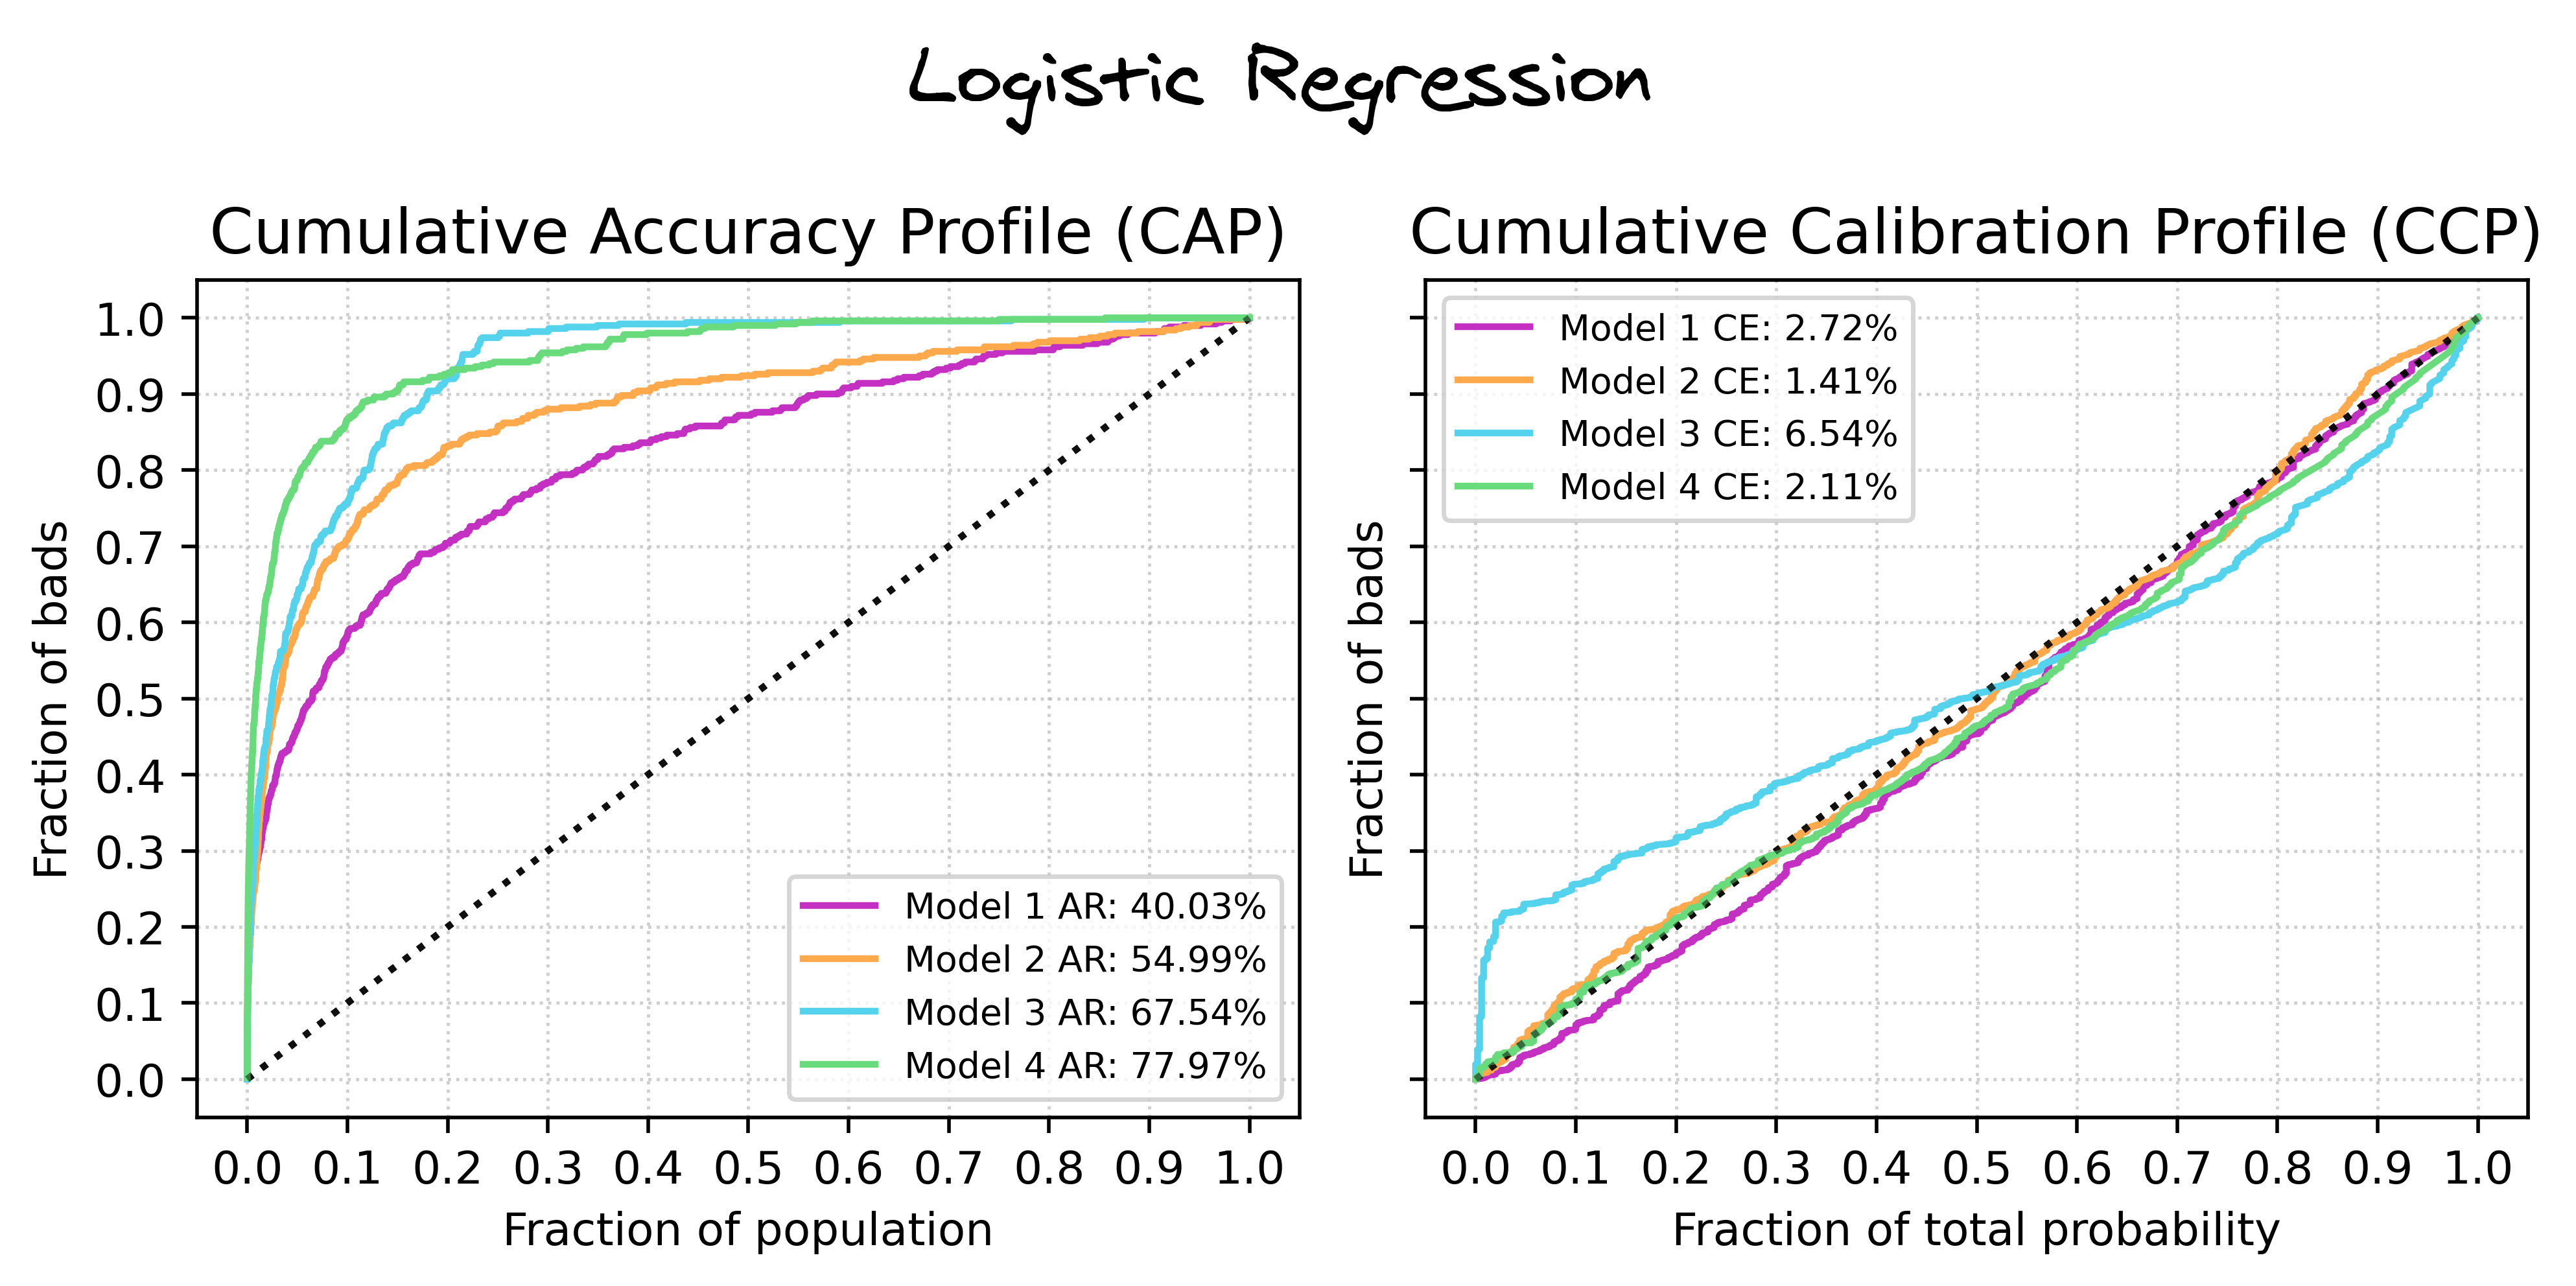

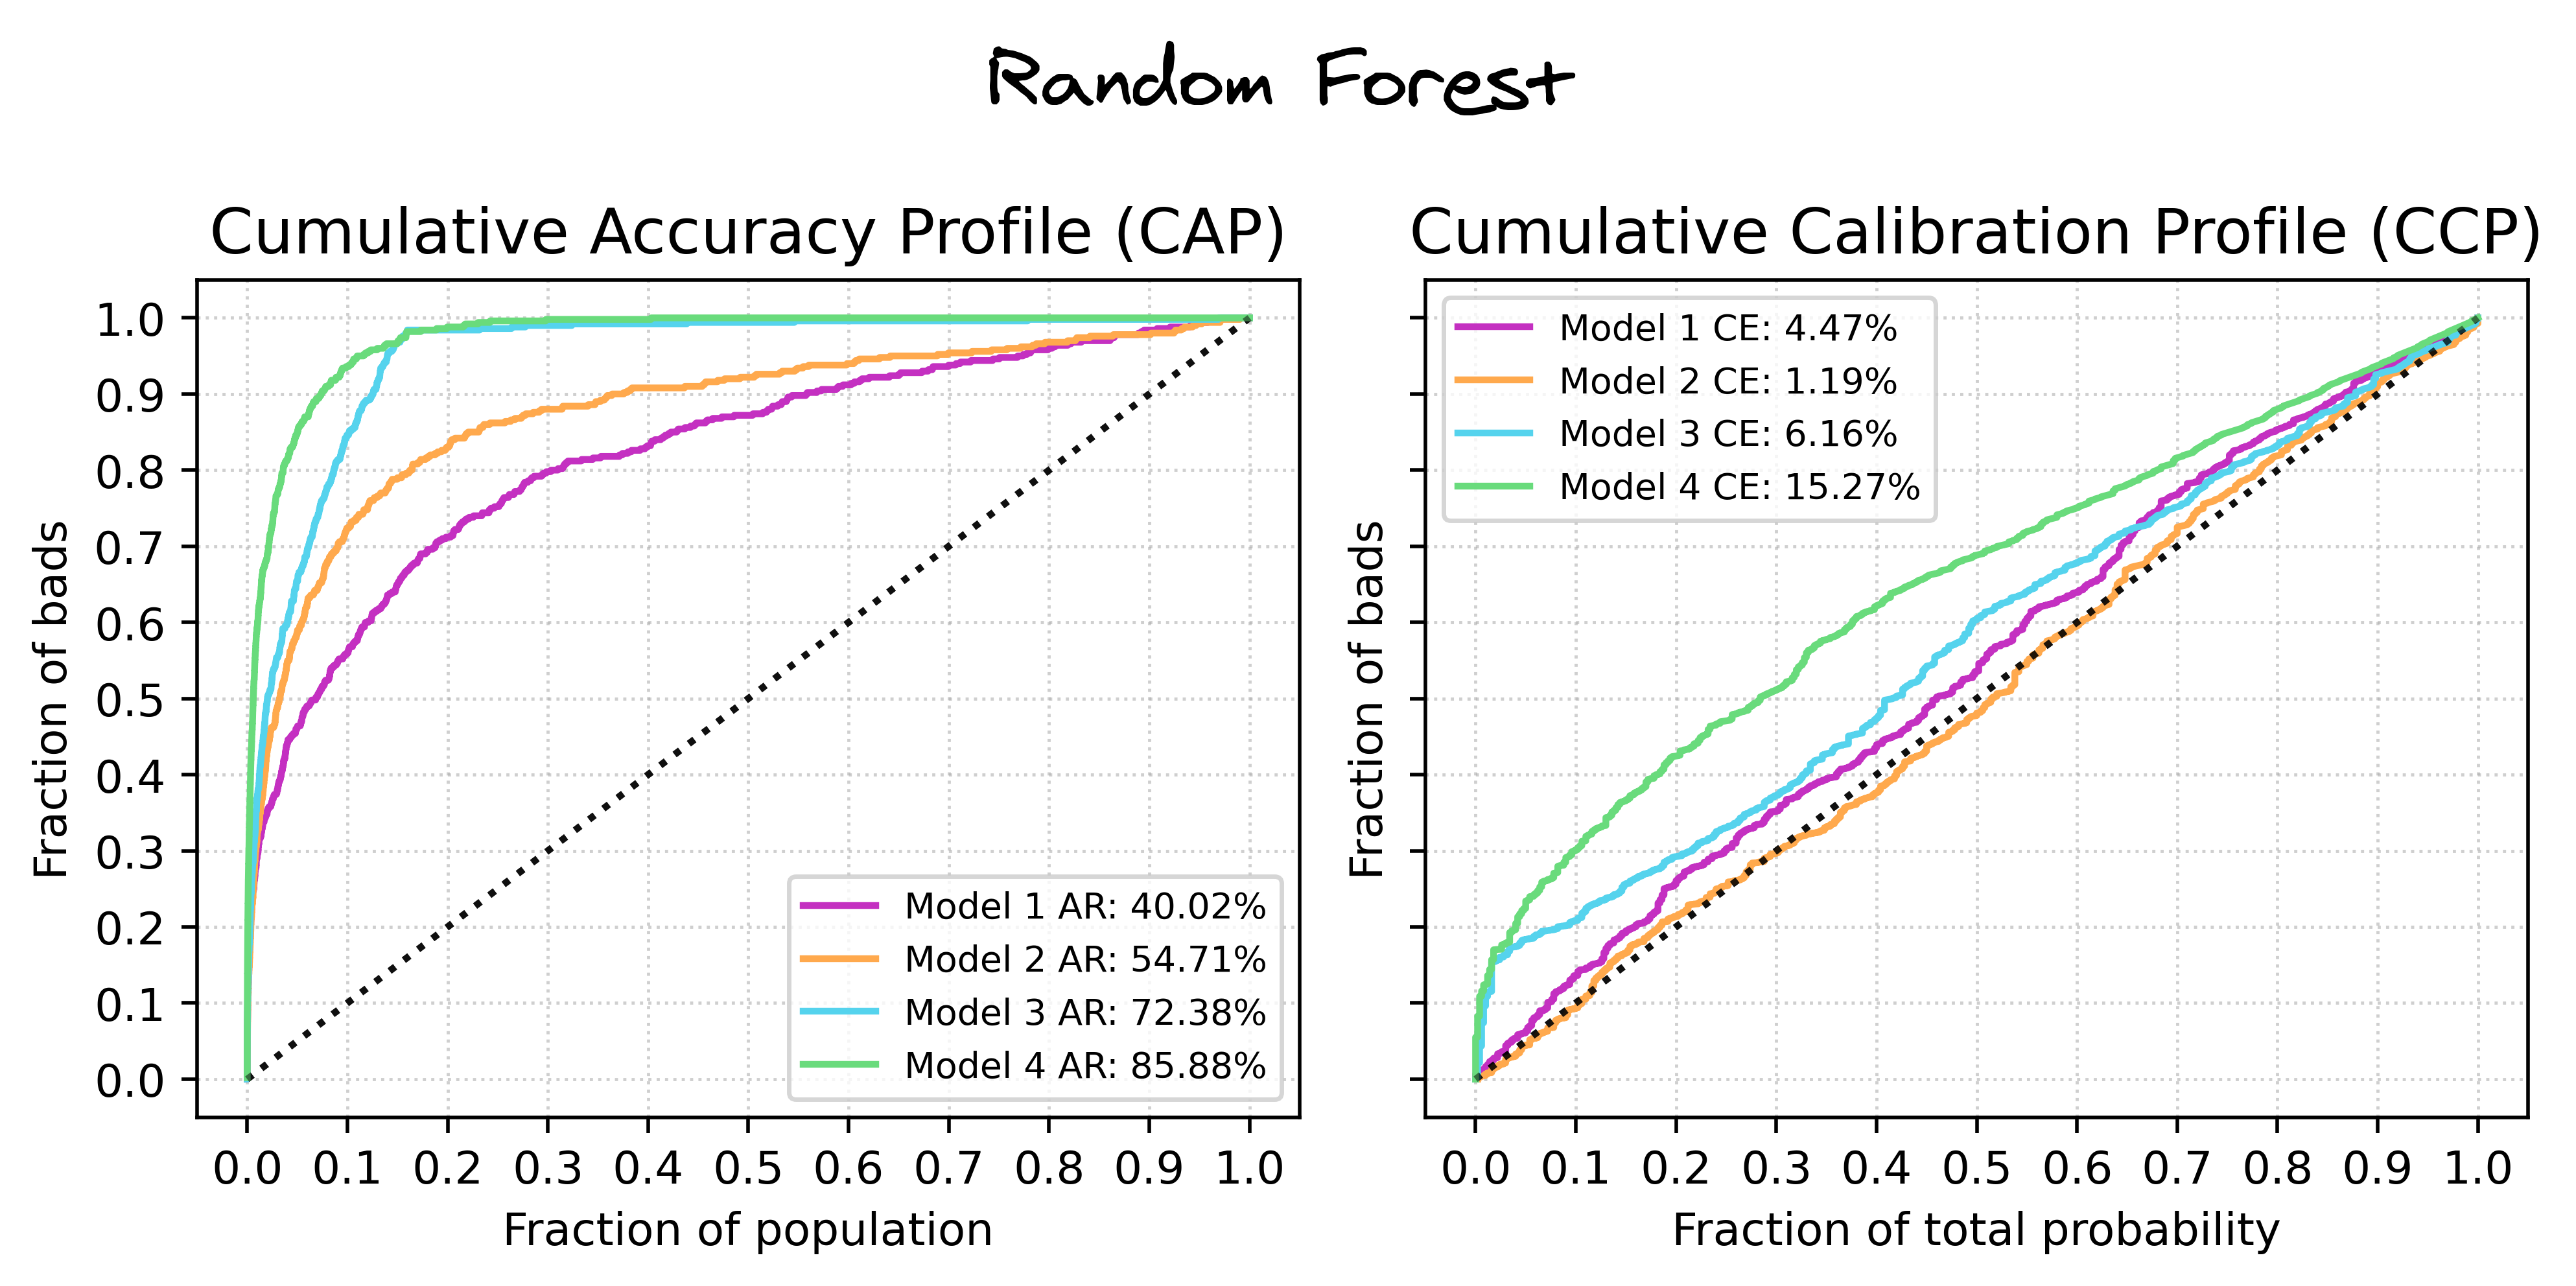

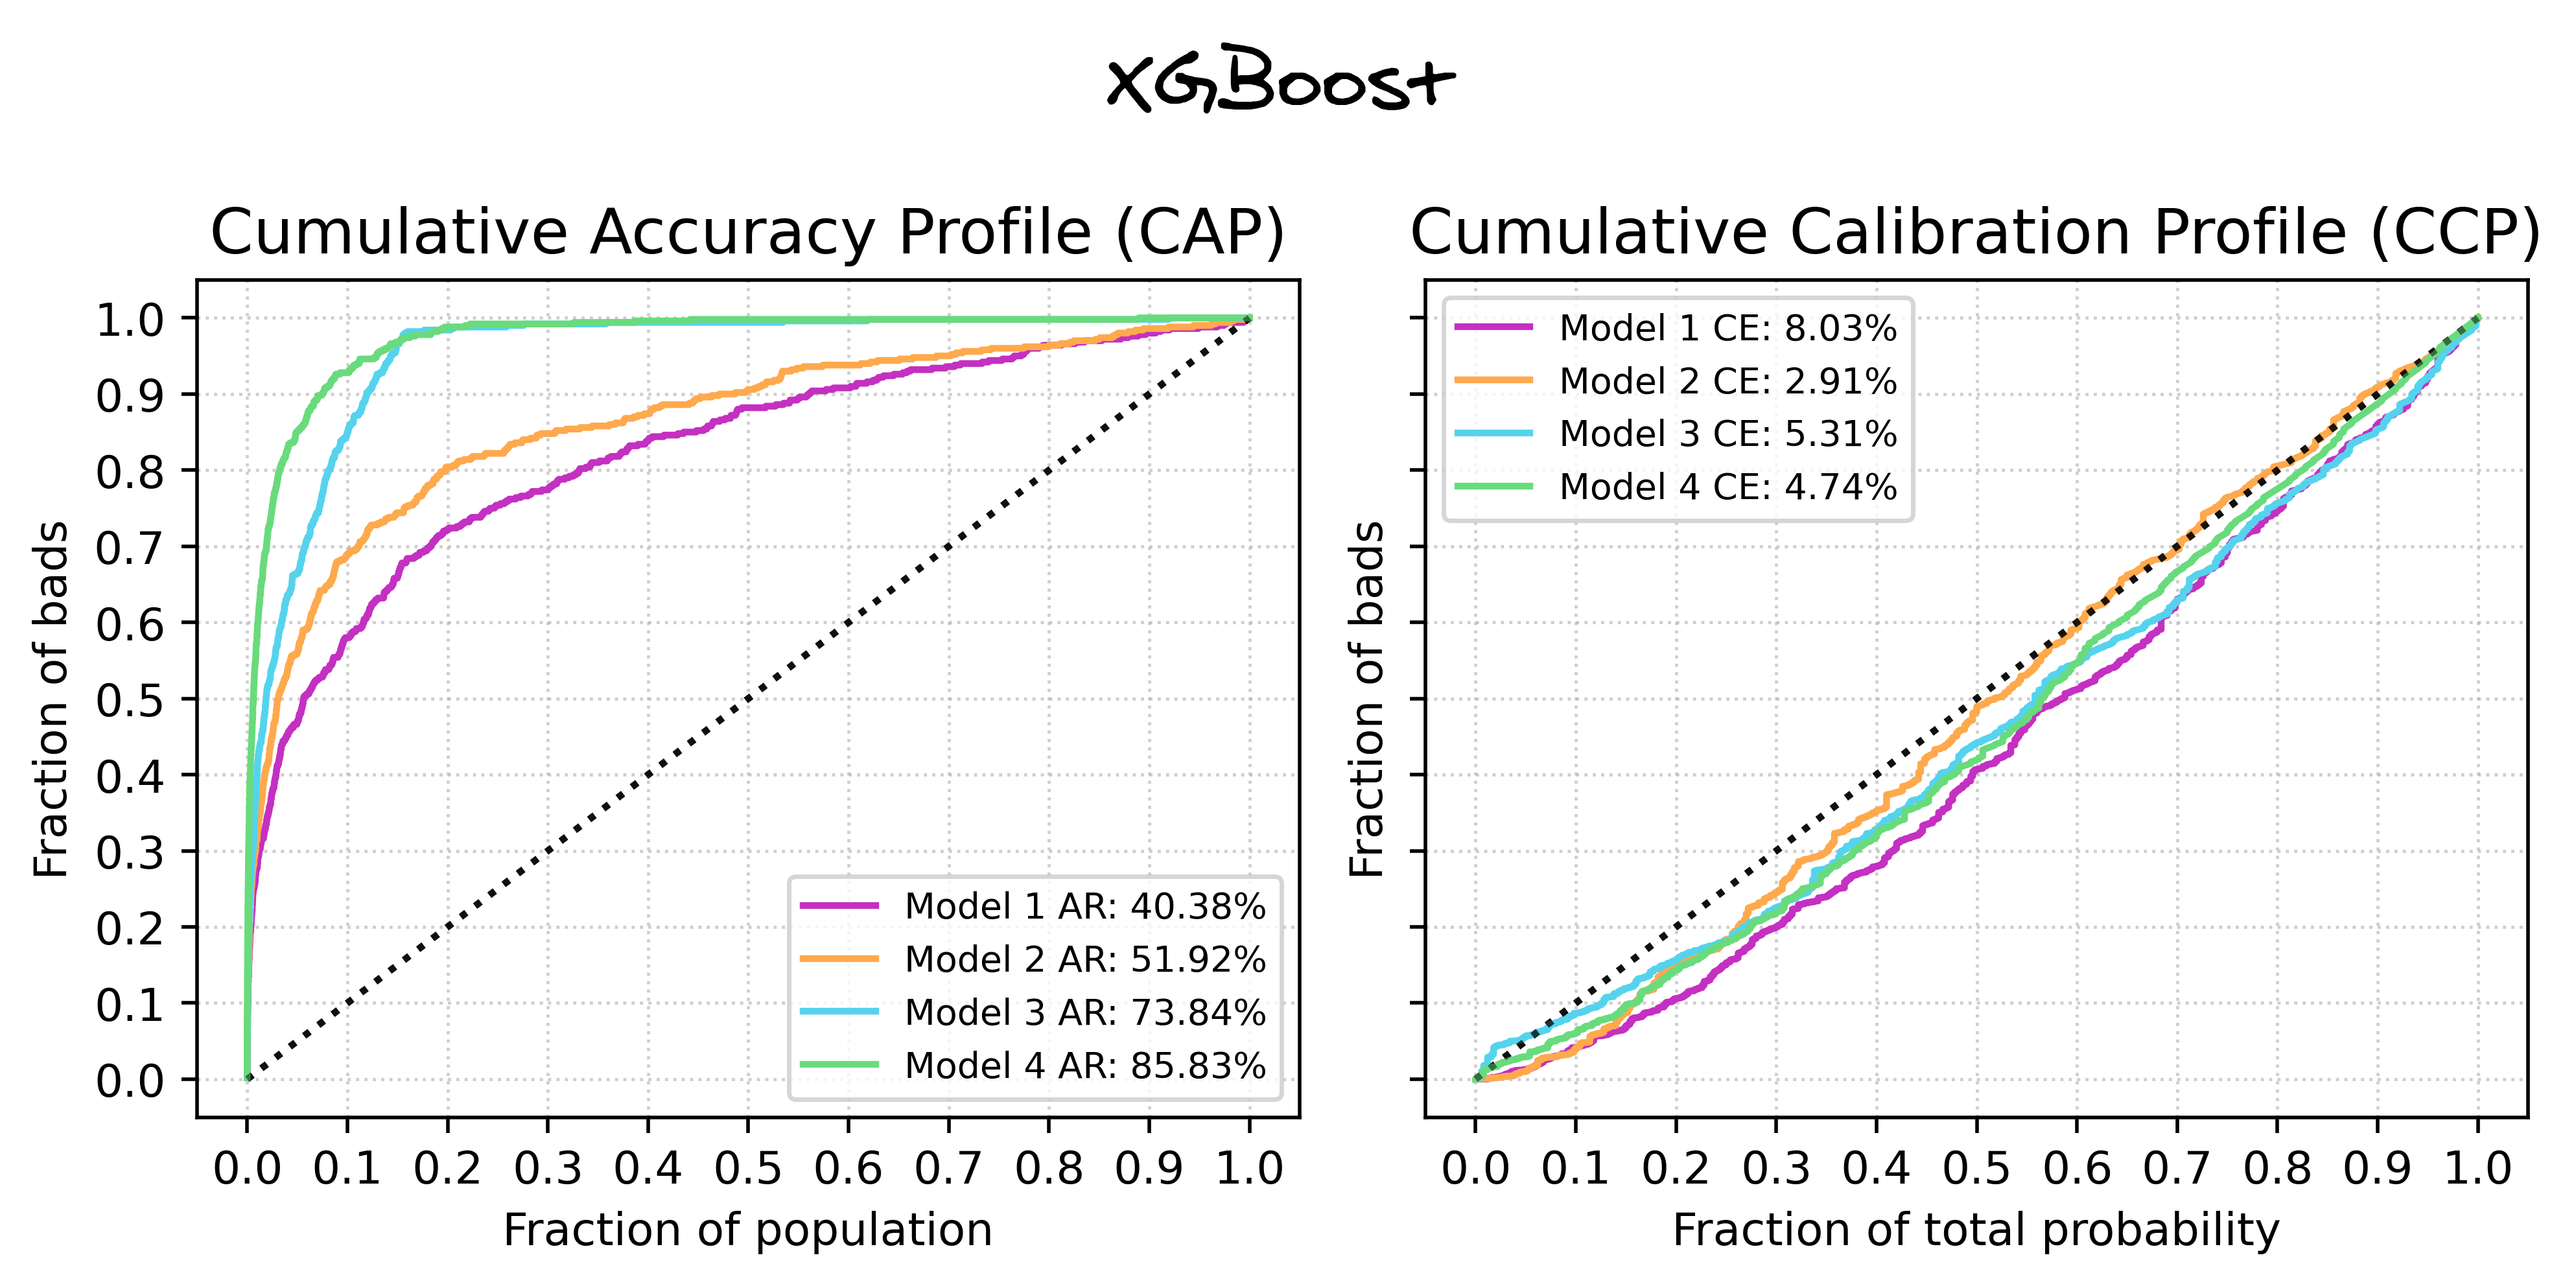

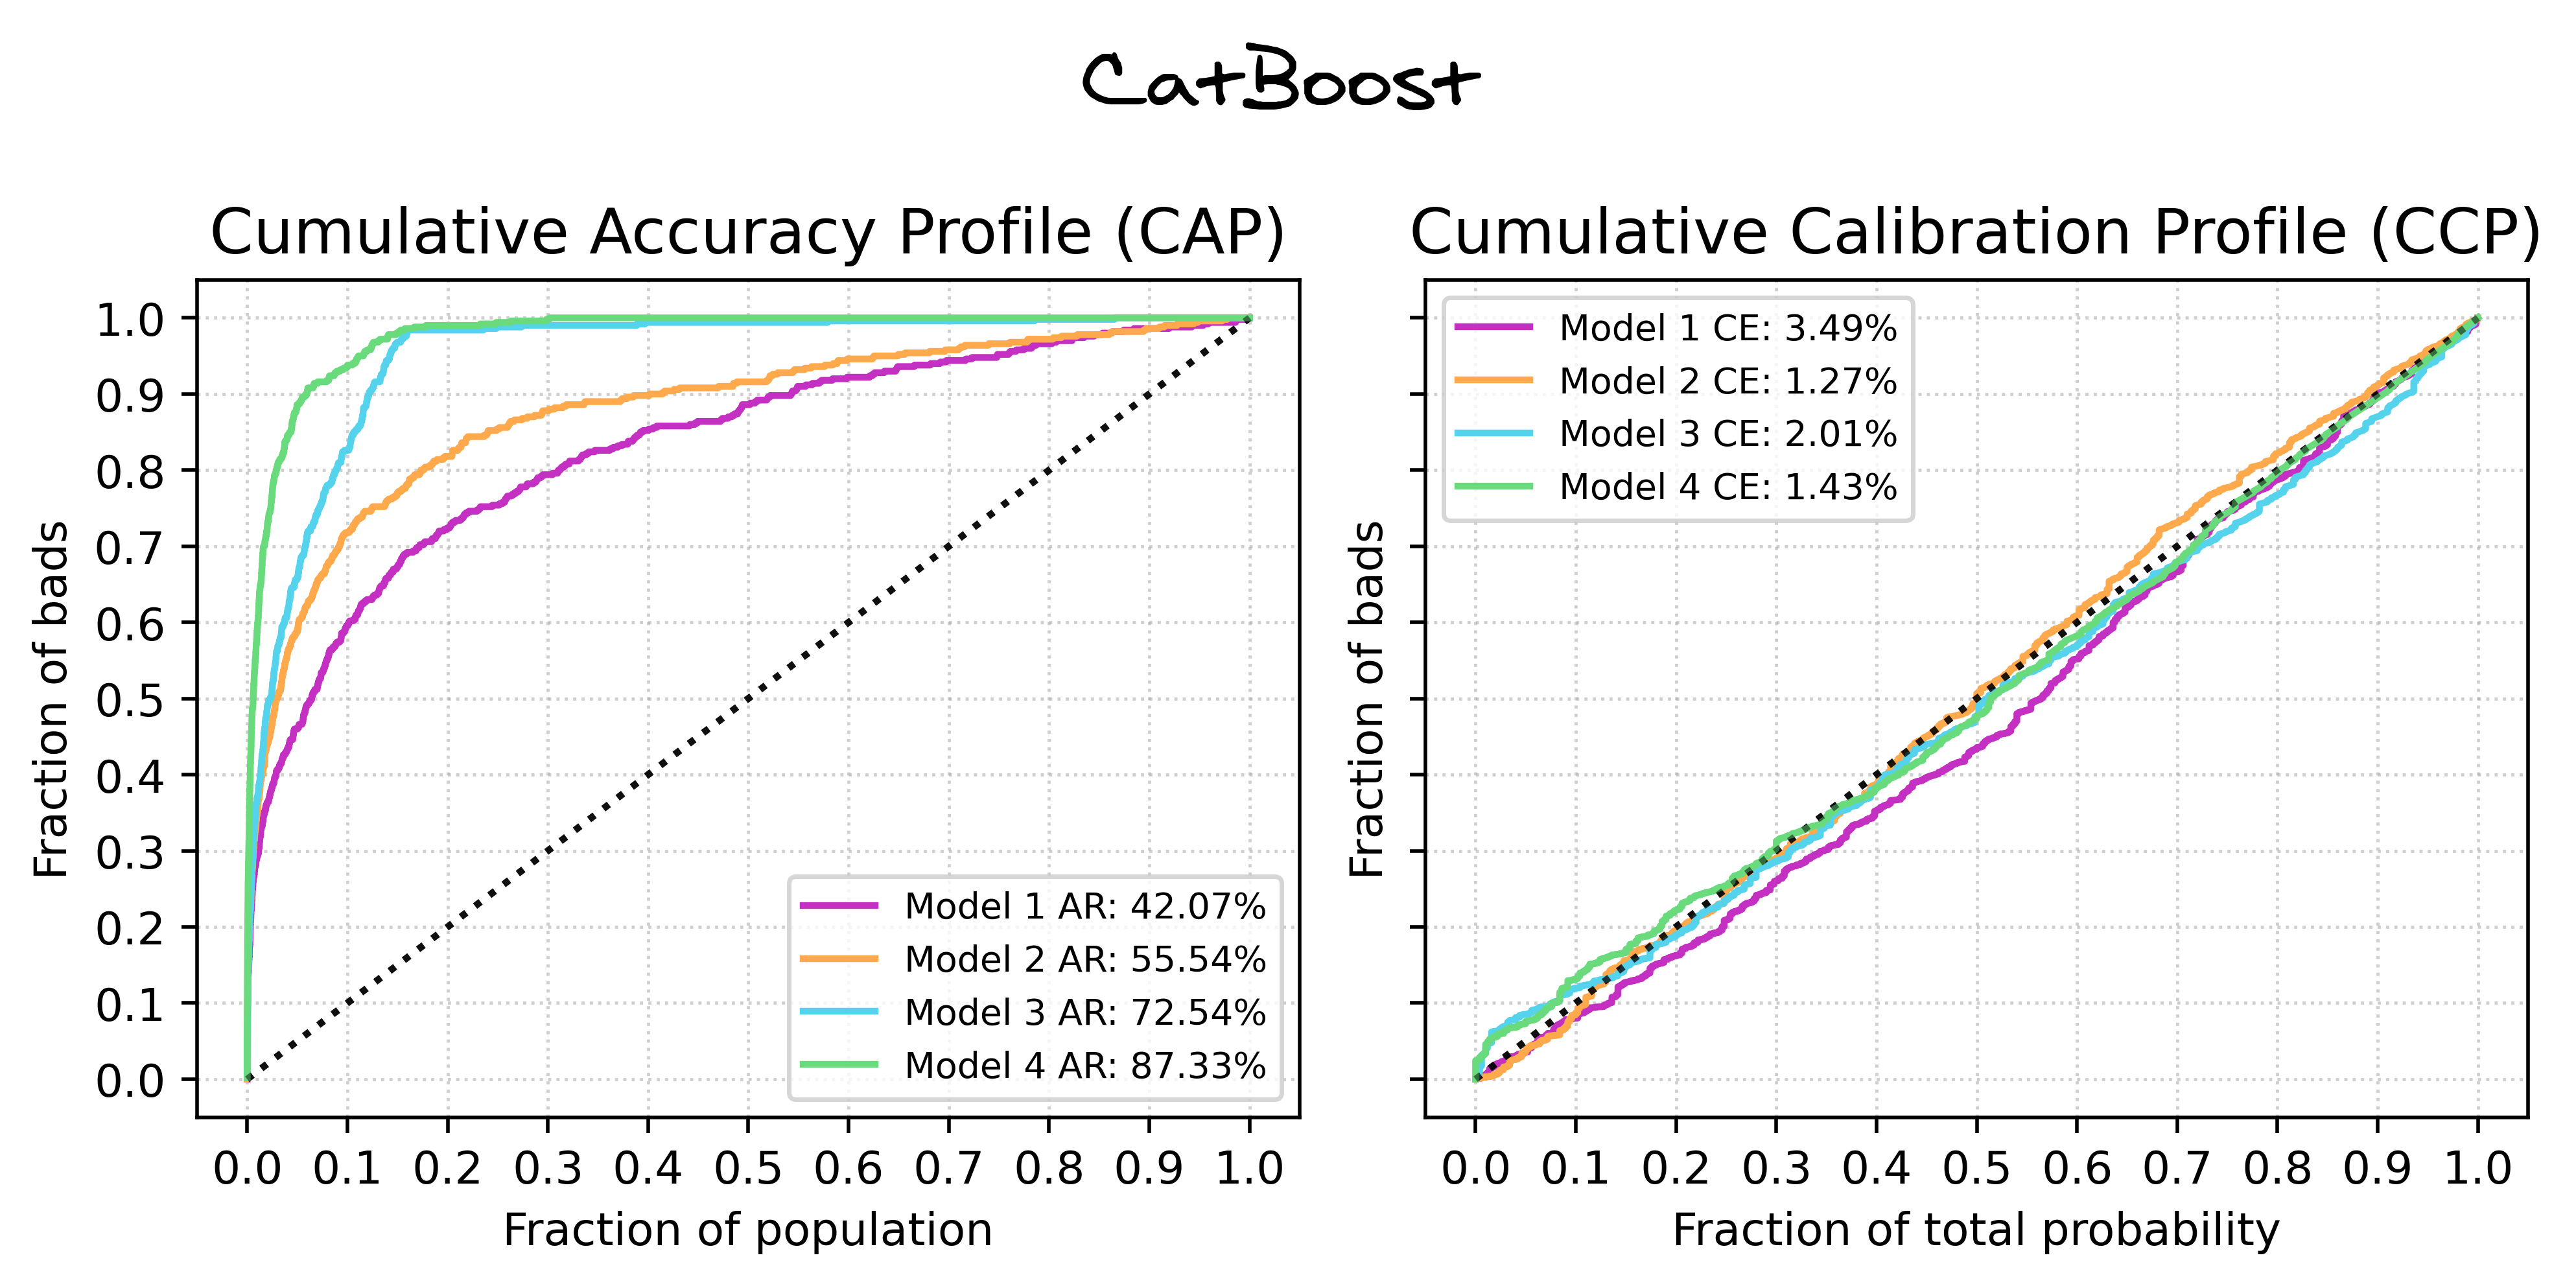

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance(models, predictions, ginis, model_name=None):
    # sourcery skip: extract-duplicate-method
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, dpi=500)
    colors = ['#c430c1', '#ffa94d', '#55d3ed', '#69db7c']

    for i, _ in enumerate(models):
        # Data preparation for CAP curve
        preds_filtered = predictions[[f"model_{i}", "label"]].copy()
        preds_filtered = preds_filtered.rename(columns={f"model_{i}": "prediction"})
        preds_filtered = preds_filtered.sort_values(
            by="prediction", ascending=False
        ).reset_index(drop=True)
        preds_filtered["id"] = preds_filtered.index
        total_id = preds_filtered["id"].sum()
        preds_filtered["cum_id"] = preds_filtered["id"].cumsum() / total_id
        cumulative_bad = preds_filtered["label"].cumsum()
        total_bad = preds_filtered["label"].sum()
        preds_filtered["cumulative_bad"] = cumulative_bad / total_bad

        # Plot CAP curve
        ax1.plot(
            preds_filtered["cum_id"],
            preds_filtered["cumulative_bad"],
            label=f'Model {i+1} AR: {ginis.loc[i, "gini"]:.2%}',
            color=colors[i],
        )

        # CAP plot formatting
        ax1.set_xticks(np.arange(0, 1.1, 0.1))
        ax1.set_yticks(np.arange(0, 1.1, 0.1))
        ax1.set_xlabel("Fraction of population")
        ax1.set_ylabel("Fraction of bads")
        ax1.set_title("Cumulative Accuracy Profile (CAP)", fontsize=14)
        ax1.grid(True, which="both", linestyle="dotted", linewidth=0.7, alpha=0.6)
        ax1.plot([0, 1], [0, 1], linestyle="dotted", color="black", alpha=0.5)

        # Data preparation for Calibration plot
        preds_filtered = predictions[[f"model_{i}", "label"]].copy()
        preds_filtered = preds_filtered.rename(columns={f"model_{i}": "prediction"})
        preds_filtered = preds_filtered.sort_values(
            by="prediction", ascending=True
        ).reset_index(drop=True)
        cumulative_bad = preds_filtered["label"].cumsum()
        total_bad = preds_filtered["label"].sum()

        preds_filtered["cumulative_bad"] = cumulative_bad / total_bad
        cumulative_prob = preds_filtered["prediction"].cumsum()
        total_prob = preds_filtered["prediction"].sum()
        preds_filtered["cumulative_prob"] = cumulative_prob / total_prob
        
        # ce = np.trapz(
        #     np.abs(preds_filtered["cumulative_bad"] - preds_filtered["cumulative_prob"]),
        #     preds_filtered["cumulative_bad"],
        # )
        
        error = np.abs(preds_filtered["cumulative_bad"] - preds_filtered["cumulative_prob"])
        ce = np.sum(error * preds_filtered["cumulative_bad"]) / np.sum(preds_filtered["cumulative_bad"])
        
        # Plot Calibration curve
        ax2.plot(
            preds_filtered["cumulative_bad"],
            preds_filtered["cumulative_prob"],
            label=f"Model {i+1} CE: {ce:.2%}",
            color=colors[i],
        )

        # Calibration plot formatting
        ax2.set_xticks(np.arange(0, 1.1, 0.1))
        ax2.set_yticks(np.arange(0, 1.1, 0.1))
        ax2.set_xlabel("Fraction of total probability")
        ax2.set_ylabel("Fraction of bads")
        ax2.set_title("Cumulative Calibration Profile (CCP)", fontsize=14)
        # ax2.legend(loc="lower right")
        ax2.grid(True, which="both", linestyle="dotted", linewidth=0.7, alpha=0.6)
        ax2.plot([0, 1], [0, 1], linestyle="dotted", color="black", alpha=0.5)
        
        ax1.legend(loc='lower right', fontsize=8)
        ax2.legend(loc='upper left', fontsize=8)

    if model_name:
        fig.suptitle(f"{model_name}", fontsize=18, fontname="Virgil GS")
    else:
        fig.suptitle("Model Performance", fontsize=18, fontname="Virgil GS")
    plt.tight_layout()
    plt.show()

# Plot performance for each model type
plot_performance(models_lr, predictions_lr, ginis_lr, model_name="Logistic Regression")
plot_performance(models_rf, predictions_rf, ginis_rf, model_name="Random Forest")
plot_performance(models_xgb, predictions_xgb, ginis_xgb, model_name="XGBoost")
plot_performance(models_cb, predictions_cb, ginis_cb, model_name="CatBoost")